### Данная работа выполнена в рамках спецкурса "ML&AI_CS 2022" ВМК МГУ.
### **Автор работы:** Васильев Юлий Алекссевич, 620 группа.

#### В работе проводится анализ набора данных, предназначенного для области анализа выживаемости. 

---

Область анализа выживаемости изучает методы оценки времени и вероятности до наступления определенного события. 

Для соблюдения рамок материалов курса, в работе проводится анализ как бинарной целевой переменной исхода пациента, так и времени наступления события.

### Импорт библиотек

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [2]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных

Набор данных, собранный c 10 января по 18 февраля 2020 года, был представлен в статье: https://www.nature.com/articles/s42256-020-0180-7. В качестве события рассматривается время выписки пациента.
 
Набор данных содержит **375** наблюдений и **76** признаков по:
*   Анамнезу
*   Результатам клинических исследований за время лечения


In [3]:
dataset_covid = '/content/covid.xlsx'
df = pd.read_excel(dataset_covid)

## Формирование признакового пространства

Пространство признаков формируется из **минимальных, максимальных и средних** показателей клинических исследований пациента. 

Все признаки набора данных могут содержать пропуски, максимальное количество пропусков имеется в показателях антитромбина и продуктах распада фибрина (173 пропуска). В конце исследования было зафиксировано 174 пациента, которые не были выписаны.

In [4]:
# Функция построения целевой переменной для анализа выживаемости
def get_y(cens,time):
    cens, time = np.array(cens), np.array(time) 
    y = np.empty(dtype=[('cens', bool), 
                        ('time', np.float64)], 
                 shape=cens.shape[0])
    y['cens'] = cens
    y['time'] = time
    return y

In [5]:
df['PATIENT_ID'] = df['PATIENT_ID'].fillna(method = 'ffill')
columns_no_agg = ['RE_DATE','age','gender','Admission time','Discharge time','outcome']
columns_agg = list(set(df.columns) - set(columns_no_agg))
df_agg = df.groupby('PATIENT_ID').agg(list)
for c in df_agg.columns:
    if c in columns_no_agg:
        df_agg[c] = df_agg[c].apply(lambda x: x[0])
    else:
        df_agg['mean_' + c] = df_agg[c].apply(np.nanmean)
        df_agg['min_' + c] = df_agg[c].apply(np.nanmin)
        df_agg['max_' + c] = df_agg[c].apply(np.nanmax)
        df_agg = df_agg.drop(c, axis = 1)
df_agg['time'] = df_agg.loc[:,['Admission time','Discharge time']].apply(lambda x: (x['Discharge time'] - x['Admission time']).days, axis = 1)
df_f = df_agg[df_agg['time'] == df_agg['time']]
df_f = df_f.drop(['RE_DATE', 'Admission time', 'Discharge time'], axis = 1)
df_f = df_f.rename({'outcome':'cens'}, axis = 1)
df_f = df_f.rename({c:re.sub('[^A-Za-z0-9_]', '_', c) for c in df_f.columns}, axis = 1)
df_f = df_f.reset_index(drop=True)

categ_covid = []
sign_covid = list(set(df_f) - {'cens', 'time'})

y = get_y(df_f['cens'], df_f['time'])
y_time = y['time'].copy()
y_cens = y['cens'].copy()
X = df_f.loc[:, sign_covid]
X = X.fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:1101: RuntimeWarning: Mean of empty slice
  convert=self.convert_dtype,
/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py:1101: RuntimeWarning: All-NaN axis encountered
  convert=self.convert_dtype,


In [6]:
import warnings
warnings.filterwarnings('ignore')

### Анализ исходов пациентов (классификация)

*   Целевая переменная: исход пациента (1 - выписан, 0 - цензурирован (умер или покинул исследование))

*   Обработка: стандартизация

*   Отбор признаков: Backward

*   Рассматриваемые модели: LogisticRegression, KNN, SVM

*   Метрика качества: ROC-AUC

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cens, stratify = y_cens, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train.values[:] = scaler.fit_transform(X_train)
X_test.values[:] = scaler.transform(X_test)

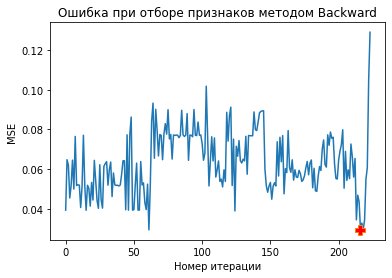

BEST FEATURES:  Index(['age', 'mean_D_D_dimer', 'min_Platelet_count', 'min_neutrophils___',
       'max_Alkaline_phosphatase', 'mean_Alkaline_phosphatase',
       'min_Hypersensitive_c_reactive_protein',
       'mean_mean_corpuscular_volume'],
      dtype='object')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Определим лучшее число признаков с помощью Backward 
def feature_selection(X_train, y_train):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train.to_numpy(), y_train, stratify = y_train, test_size=0.3, random_state=42)
    best_feats = None
    features = list(range(X_tr.shape[1]))
    errs = []
    while len(features) > 0:
        lr = LogisticRegression()
        lr.fit(X_tr[:, features], y_tr)
        err = mean_squared_error(y_val, lr.predict_proba(X_val[:, features])[:,1])
        errs.append(err)
        if min(errs) == err:
            best_feats = features.copy()

        model = sm.OLS(y_tr, X_tr[:, features])
        res = model.fit()

        # Выбираем худший признак и удаляем из пространства признаков
        worse_feature = features[np.argmax(res.pvalues)]
        features.remove(worse_feature)

    # Визуализируем ошибки
    idx = len(errs) - len(best_feats)
    plt.plot(errs)
    plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
    plt.xlabel("Номер итерации")
    plt.ylabel("MSE")
    plt.title("Ошибка при отборе признаков методом Backward")
    plt.show()
    return X_train.columns[best_feats]
best_feats = feature_selection(X_train, y_train)
print("BEST FEATURES: ", best_feats)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
print("LogisticRegression. ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

model = LogisticRegression()
model.fit(X_train.loc[:, best_feats], y_train)
print("LogisticRegression + Selection. ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test.loc[:, best_feats])[:,1]))

LogisticRegression. ROC-AUC:  0.9735182849936947
LogisticRegression + Selection. ROC-AUC:  0.9877049180327868


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

for k in [3, 5, 10, 15, 20]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    print(f"KNeighborsClassifier (K = {k}). ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train.loc[:, best_feats], y_train)
    print(f"KNeighborsClassifier + Selection(K = {k}). ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test.loc[:, best_feats])[:,1]))

KNeighborsClassifier (K = 3). ROC-AUC:  0.9404161412358135
KNeighborsClassifier + Selection(K = 3). ROC-AUC:  0.9670554854981085
KNeighborsClassifier (K = 5). ROC-AUC:  0.9497162673392181
KNeighborsClassifier + Selection(K = 5). ROC-AUC:  0.9720996216897856
KNeighborsClassifier (K = 10). ROC-AUC:  0.9487704918032787
KNeighborsClassifier + Selection(K = 10). ROC-AUC:  0.9700504413619168
KNeighborsClassifier (K = 15). ROC-AUC:  0.9495586380832283
KNeighborsClassifier + Selection(K = 15). ROC-AUC:  0.9777742749054226
KNeighborsClassifier (K = 20). ROC-AUC:  0.9557061790668347
KNeighborsClassifier + Selection(K = 20). ROC-AUC:  0.9706809583858764


In [ ]:
from sklearn.svm import SVC

for kernel in ['linear', 'poly', 'rbf']:
    model = SVC(kernel = kernel, gamma='auto', probability=True)
    model.fit(X_train, y_train)
    print(f"SVM (kernel = {kernel}). ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    model = SVC(kernel = kernel, gamma='auto', probability=True)
    model.fit(X_train.loc[:, best_feats], y_train)
    print(f"SVM + Selection(kernel = {kernel}). ROC-AUC: ", roc_auc_score(y_test, model.predict_proba(X_test.loc[:, best_feats])[:,1]))

SVM (kernel = linear). ROC-AUC:  0.9722572509457756
SVM + Selection(kernel = linear). ROC-AUC:  0.9886506935687264
SVM (kernel = poly). ROC-AUC:  0.905422446406053
SVM + Selection(kernel = poly). ROC-AUC:  0.9672131147540983
SVM (kernel = rbf). ROC-AUC:  0.5343631778058009
SVM + Selection(kernel = rbf). ROC-AUC:  0.6592055485498108


Выводы:

1.   После отбора осталось всего 8 признаков. Признаки выглядят логично: в врачебной практике очень часто важны признаки CRB, D-dimer и возраст.
2.   Предварительный отбор признаков для всех моделей повысил качество прогноза на тестовой выборке. 
3.   Лучшее качество прогноза достигнуто на модели опорных векторов, однако при смене ядра прогноз модели нестабилен.

Топ-3 модели прогозирования исхода пациента:
> **SVM + Selection(kernel = linear). ROC-AUC:  0.98865** 

> **LogisticRegression + Selection. ROC-AUC:  0.98770** 

> **KNeighborsClassifier + Selection(K = 15). ROC-AUC:  0.97777** 

## Анализ времени выписки пациентов (регрессия)

*   Целевая переменная: время выписки пациента (или до момента цензурирования)

*   Обработка: стандартизация (и признаков, и отклика)

*   Отбор признаков: Forward с LinearRegression

*   Рассматриваемые модели: LinearRegression, KNN

*   Метрика качества: MSE

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_time, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train.values[:] = scaler.fit_transform(X_train)
X_test.values[:] = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).reshape(1,-1)[0]
y_test = y_scaler.transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

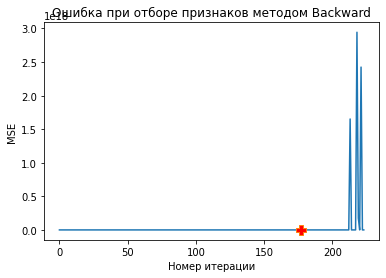

BEST FEATURES:  Index(['min_Fibrin_degradation_products', 'max_Alkaline_phosphatase',
       'min_glucose', 'mean_HIV_antibody_quantification',
       'min_HIV_antibody_quantification', 'max_HIV_antibody_quantification',
       'mean_fibrinogen', 'mean_basophil_count___', 'max_basophil_count___',
       'min_lymphocyte_count', 'max_Platelet_count', 'min_basophil_count___',
       'max_HBsAg', 'min_Eosinophil_count', 'mean_Mean_platelet_volume',
       'max_Activation_of_partial_thromboplastin_time', 'min_monocytes_count',
       'mean_mean_corpuscular_hemoglobin_', 'min_HBsAg',
       'mean_Serum_potassium', 'max_International_standard_ratio',
       'mean_Eosinophil_count', 'mean_Total_cholesterol',
       'mean_lymphocyte_count', 'mean_calcium',
       'max_HCV_antibody_quantification',
       'min_Quantification_of_Treponema_pallidum_antibodies',
       'mean_Quantification_of_Treponema_pallidum_antibodies',
       'max_Eosinophil_count', 'mean_thrombocytocrit', 'max_Thrombin_time',

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Определим лучшее число признаков с помощью Forward 
def feature_selection(X_train, y_train):
    X_tr, X_val, y_tr, y_val = train_test_split(X_train.to_numpy(), y_train, test_size=0.3, random_state=42)
    best_feats = None
    sec_features = []
    features = list(range(X_tr.shape[1]))
    errs = []
    while len(features) > 0:
        model = sm.OLS(y_tr, X_tr[:, features])
        res = model.fit()

        # Выбираем лучший признак и добавляем в пространство признаков
        best_feature = features[np.argmin(res.pvalues)]
        sec_features.append(best_feature)
        features.remove(best_feature)

        lr = LinearRegression()
        lr.fit(X_tr[:, sec_features], y_tr)
        err = mean_squared_error(y_val, lr.predict(X_val[:, sec_features]))
        errs.append(err)
        if min(errs) == err:
            best_feats = sec_features.copy()

    # Визуализируем ошибки
    idx = len(errs) - len(best_feats)
    plt.plot(errs)
    plt.plot(idx, errs[idx], 'P', ms=10, mfc='red')
    plt.xlabel("Номер итерации")
    plt.ylabel("MSE")
    plt.title("Ошибка при отборе признаков методом Backward")
    plt.show()
    return X_train.columns[best_feats]
best_feats = feature_selection(X_train, y_train)
print("BEST FEATURES: ", best_feats)

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)
print("LinearRegression. MSE: ", mean_squared_error(y_test, model.predict(X_test)))

model = LinearRegression()
model.fit(X_train.loc[:, best_feats], y_train)
print("LinearRegression + Selection. MSE: ", mean_squared_error(y_test, model.predict(X_test.loc[:, best_feats])))

LinearRegression. MSE:  2621803556753615.5
LinearRegression + Selection. MSE:  0.7998589966253797


In [32]:
from sklearn.neighbors import KNeighborsRegressor

for k in [3, 5, 10, 15, 20]:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    print(f"KNeighborsRegressor (K = {k}). MSE: ", mean_squared_error(y_test, model.predict(X_test)))

    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train.loc[:, best_feats], y_train)
    print(f"KNeighborsRegressor (K = {k}) + Selection. MSE: ", mean_squared_error(y_test, model.predict(X_test.loc[:, best_feats])))

KNeighborsRegressor (K = 3). MSE:  0.6496159262419812
KNeighborsRegressor (K = 3) + Selection. MSE:  0.777973583291216
KNeighborsRegressor (K = 5). MSE:  0.5531411902855856
KNeighborsRegressor (K = 5) + Selection. MSE:  0.6492896701652761
KNeighborsRegressor (K = 10). MSE:  0.5147226586197076
KNeighborsRegressor (K = 10) + Selection. MSE:  0.5444055429342657
KNeighborsRegressor (K = 15). MSE:  0.5090308677460169
KNeighborsRegressor (K = 15) + Selection. MSE:  0.5251614440988952
KNeighborsRegressor (K = 20). MSE:  0.4847604449362143
KNeighborsRegressor (K = 20) + Selection. MSE:  0.5366741427845025


Выводы:

1.   После отбора осталось 47 признаков.
2.   Предварительный отбор признаков не всегда повышал качество прогноза на тестовой выборке.
3.   Лучшее качество прогноза достигнуто на KNN

Топ-3 модели прогозирования исхода пациента:
> **KNeighborsRegressor (K = 20). MSE:  0.4847604449362143** 

> **KNeighborsRegressor (K = 15). MSE:  0.5090308677460169** 

> **KNeighborsRegressor (K = 10). MSE:  0.5147226586197076** 